## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai import*
import numpy as np

In [4]:
suffixe = ''
path_lbl = 'data%s/labels/'% suffixe 
path_img = 'data%s/images/'% suffixe 

# Importing data

- Server: Import .mat to raw_data/matlab 
- Import.mat : Create labels files in raw_data folder and images in data_th
- Adapted Mask : Change the labels files format 

## Look at the data

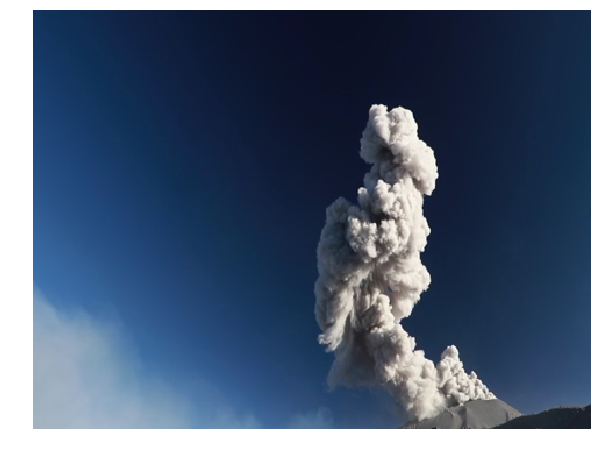

In [10]:
img_f = path_img+'mask4_00021.png'
img = open_image(img_f)
img.show(figsize=(10,10))

In [6]:
get_label = lambda x: path_lbl+x.stem+x.suffix

In [1]:
mask = open_mask('data%s/labels/mask4_00021.png'%suffixe )
mask.show(figsize=(10,10), alpha=1)

NameError: name 'open_mask' is not defined

In [66]:
src_size = np.array(mask.shape[1:])
mask.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

## Datasets

In [67]:
classes = np.array(['other','plume'],dtype='<U17')

In [68]:
size = src_size//6
bs = 4
gc.collect()

3933

In [107]:
# Choosing the validation set(s)
set_number = [] # Change this to choose your validation files
valid_names = [] # Not this !
for root, dirs, files in os.walk(path_img):
    files = sorted(files)
    for filename in files: 
        if filename[:4] == 'mask': # verify that its not a weird file
            if int(filename[4]) in set_number:
                valid_names.append(filename)

In [108]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_files(valid_names)
       .label_from_func(get_label, classes=classes))
src

/opt/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:445: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


LabelLists;

Train: LabelList (51 items)
x: SegmentationItemList
Image (3, 360, 640),Image (3, 360, 640),Image (3, 360, 640),Image (3, 360, 640),Image (3, 360, 640)
y: SegmentationLabelList
ImageSegment (1, 360, 640),ImageSegment (1, 360, 640),ImageSegment (1, 360, 640),ImageSegment (1, 360, 640),ImageSegment (1, 360, 640)
Path: data_exp/images;

Valid: LabelList (0 items)
x: SegmentationItemList

y: SegmentationLabelList

Path: data_exp/images;

Test: None

In [109]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [110]:
#data.show_batch(2, imsize = 3)

## Model

In [75]:
#name2id = {v:k for k,v in enumerate(classes)}
#void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target #!= void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [76]:
#metrics=acc_camvid
wd=1e-2

In [77]:
learn = unet_learner(data, models.resnet34, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


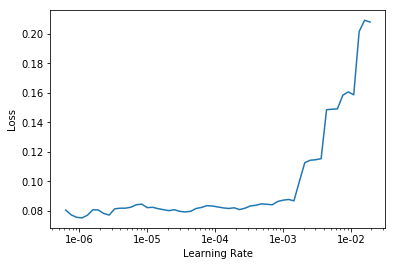

In [82]:
lr_find(learn)
learn.recorder.plot()

In [79]:
lr=1e-4

In [80]:
learn.fit_one_cycle(8, lr)

epoch,train_loss,valid_loss,time
0,0.325488,0.239331,00:01
1,0.244409,0.150072,00:01
2,0.189196,0.087637,00:01
3,0.157806,0.081171,00:01
4,0.138000,0.066944,00:01
5,0.123738,0.069653,00:01
6,0.112602,0.062430,00:01
7,0.104042,0.061915,00:01


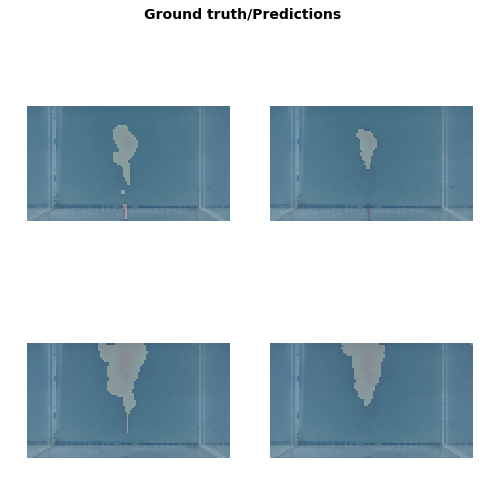

In [81]:
learn.show_results(rows=2, imsize = 2)

In [83]:
learn.save('stage-1');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [84]:
size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 6578MB of GPU RAM free


In [85]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [86]:
learn = unet_learner(data, models.resnet34, wd=wd)

In [87]:
learn.load('stage-1');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


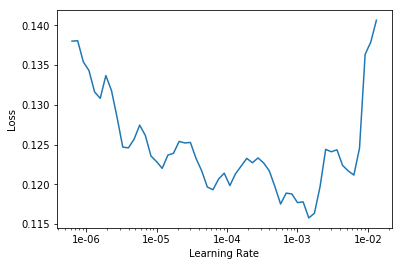

In [88]:
lr_find(learn)
learn.recorder.plot()

In [89]:
lr=4e-4

In [90]:
learn.fit_one_cycle(10,lr)

epoch,train_loss,valid_loss,time
0,0.109332,0.086213,00:13
1,0.106726,0.157072,00:11
2,0.103552,0.079714,00:11
3,0.101116,0.052404,00:11
4,0.095342,0.058425,00:11
5,0.089358,0.050816,00:11
6,0.084493,0.048629,00:11
7,0.081611,0.050156,00:11
8,0.079458,0.051008,00:11
9,0.077706,0.050762,00:11


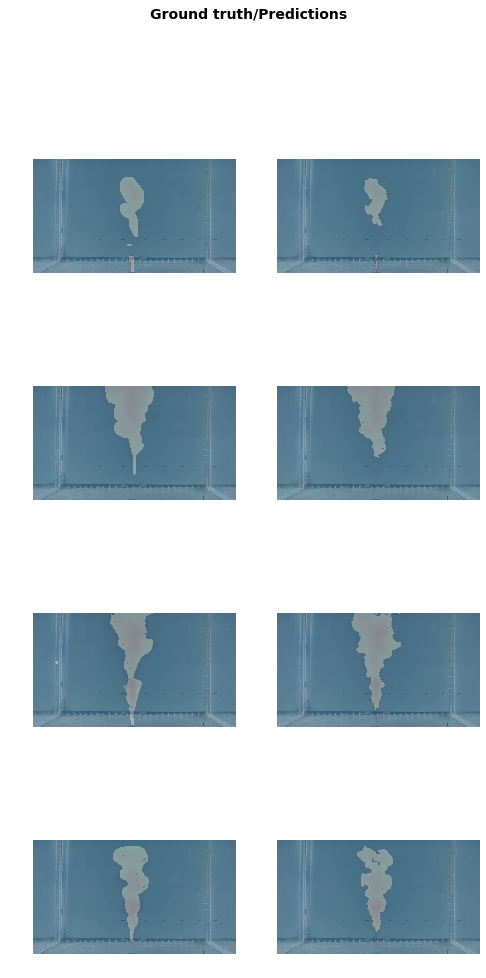

In [93]:
learn.show_results(rows=4)

In [92]:
learn.save('sgm_learner_exp');

# Save preditions

In [121]:
from PIL import Image
import matplotlib.pyplot as plt

In [122]:
path_pred = 'raw_data/predictions_exp/'
!rm -r $path_pred
!mkdir $path_pred

In [123]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    for batch in dl:
        preds = learn.pred_batch(batch=batch, reconstruct=True)
        for o in preds:
            o.save(path_pred+names[i].name)
            i += 1

In [124]:
save_preds(data.fix_dl);

In [119]:
def substract_mask(img, mask):
    pixelsMask = mask.load()
    pixelsNew = img.load()
    for i in range(img.size[0]):
        for j in range(img.size[1]):
            if pixelsMask[i,j][0] >240:
                pixelsNew[i,j] = (0,0,0)
    return(img)

In [120]:
#for root, dirs, files in os.walk(path_img):
#    for filename in files:
#        if filename[:4] == 'mask':
#            img = Image.open(path_img+filename)
#            mask = Image.open(path_pred+filename)
#            new_img = substract_mask(img, mask)
#            new_img.save(path_pred+filename)
            

# Predict test folder

In [35]:
src_test = (SegmentationItemList.from_folder('raw_data/test/')
       .split_none()
      .label_empty())

data_test = (src.transform(get_transforms(max_rotate=0, do_flip = False), size=size)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
data_test;

In [84]:
img = data_test.train_ds[1][0]
#img.show(y=learn.predict(img)[0], figsize = (8,8))
img_pred = learn.predict(img)[0]
img

NameError: name 'data_test' is not defined

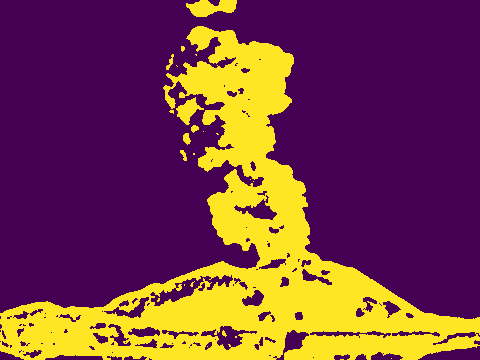

In [43]:
img_pred